In [2]:
%matplotlib inline

import pymongo
import seaborn as sns

In [3]:
import pandas as pd

def group_by(df, bycols, agg_map):
    """

    @param df:      DataFrame
    @param bycols:  str or list
                        Column(s) to group by
    @param agg_map: dictionary or list of 2-tuples
                        Mapping from column to aggregate function e.g. [("city", "count"), ("salary", "mean"]
    @return:        DataFrame
                        Flattened dataframe, with multi-level index removed
    """
    grps = []
    if type(bycols) == str:
        bycols = [bycols]

    if type(agg_map) == dict:
        agg_map = agg_map.items()

    for k,v in agg_map:
        grp = df[bycols + [k]].groupby(bycols, ).agg(v)
        grp.reset_index(inplace=True)
        grp["%s(%s)" % (v,k)] = grp[k]
        del grp[k]
        grps.append(grp)

    m = grps[0]
    for grp in grps[1:]:
        m = pd.merge(m, grp, on=bycols, how="inner")
    return m

In [13]:
client = pymongo.MongoClient()
db = client.metrics_causal_model

cb_td, cb_vd=  "CB_RE-RANKER_HYPER_PARAM_TD", "CB_RE-RANKER_HYPER_PARAM_VD"
# set to be the same for now
sc_td, sc_vd = "CB_RE-RANKER_HYPER_PARAM_TD", "CB_RE-RANKER_HYPER_PARAM_VD"

cb_td, cb_vd = db[cb_td], db[cb_vd]
sc_td, sc_vd = db[sc_td], db[sc_vd]

cb_td, cb_vd , sc_td, sc_vd

(Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model'), 'CB_RE-RANKER_HYPER_PARAM_TD'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model'), 'CB_RE-RANKER_HYPER_PARAM_VD'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model'), 'CB_RE-RANKER_HYPER_PARAM_TD'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model'), 'CB_RE-RANKER_HYPER_PARAM_VD'))

# Query Top Features

In [14]:
from pprint import pprint
from bson.son import SON # needed to ensure dictionary is ordered (python default is not)

feats_pipeline = [{
    "$project": { 
            "weighted_f1_score":"$WEIGHTED_MEAN_CONCEPT_CODES.f1_score",
            "micro_f1_score":  "$MICRO_F1.f1_score",
            "micro_recall":    "$MICRO_F1.recall",
            "micro_precision": "$MICRO_F1.precision",
            "stemmed":        "$parameters.stemmed",
            "num_feats":      "$parameters.num_feats_MEAN",
            "feats":          "$parameters.extractors",
            "count": {        "$size" : "$parameters.extractors" },
            "asof" :          "$asof",
            "_id":1
    }
},
{
    "$match":{
        "micro_f1_score": { "$exists" : True },
        # how many feats
        #"count": {          "$eq" :1 },
        # window width
        #"window_size": {    "$eq":13 }
    }
},
{
    "$sort":{
        #"weighted_f1_score":-1,
        "micro_f1_score": -1
        #"asof": -1
        #"count": -1
    }
},
]

cb_td_rows = [row for row in cb_td.aggregate(feats_pipeline)]
cb_vd_rows = [row for row in cb_vd.aggregate(feats_pipeline)]
sc_td_rows = [row for row in sc_td.aggregate(feats_pipeline)]
sc_vd_rows = [row for row in sc_vd.aggregate(feats_pipeline)]

print(len(cb_td_rows), len(cb_vd_rows), len(sc_td_rows), len(sc_vd_rows))

274 274 274 274


In [15]:
def hash_feats(fts):
    return "|".join(sorted(fts))

def get_df_sorted_by_f1score(rows):
    df = pd.DataFrame(rows).sort_values("micro_f1_score", ascending=False)
    df["hs_feats"] = df["feats"].apply(hash_feats)
    return df

cb_td_df = get_df_sorted_by_f1score(cb_td_rows)
cb_vd_df = get_df_sorted_by_f1score(cb_vd_rows)
sc_td_df = get_df_sorted_by_f1score(sc_td_rows)
sc_vd_df = get_df_sorted_by_f1score(sc_vd_rows)

cb_vd_df.head(3)

,_id,asof,count,feats,micro_f1_score,micro_precision,micro_recall,weighted_f1_score,hs_feats
0,5d02ef5be116f5bea3c0b561,2019-06-14 01:50:35.450,3,"[CREL_, Prob-, CChainStats-]",0.746779,0.789110,0.708759,0.0,CChainStats-|CREL_|Prob-
1,5d029770e116f5bea3c0b429,2019-06-13 19:35:28.095,3,"[CREL_, Prob-, CChainStats-]",0.745737,0.784994,0.710219,0.0,CChainStats-|CREL_|Prob-
2,5d02decce116f5bea3c0b521,2019-06-14 00:39:56.654,3,"[CREL_, Prob-, CChainStats-]",0.745731,0.776680,0.717153,0.0,CChainStats-|CREL_|Prob-


In [16]:
min(cb_vd_df["asof"].values),max(cb_vd_df["asof"].values)

(numpy.datetime64('2019-06-13T18:06:40.303000000'),
 numpy.datetime64('2019-06-14T04:36:47.375000000'))

In [17]:
cols = "feats,count,micro_f1_score,micro_recall,micro_precision".split(",")

def feat_name(ft):
    if type(ft) == list:
        ft=",".join(ft)
    offset = (11-1)/2
    offset_lbl = "offset:%i" % offset
    ft=ft.replace(offset_lbl, "").replace("fn_", "").replace(" ","")
    return ft

def get_top_individual_feats(df):
    df_top_individual_feats = df[(df["count"] == 1)][cols]
    df_top_individual_feats["rank"] = np.arange(len(df_top_individual_feats)) + 1
    df_top_individual_feats["feats"] = df_top_individual_feats["feats"].apply(feat_name)
    return df_top_individual_feats

#get_top_individual_feats(cb_vd_df, False)

### Performance of Each Feature In Isolation

In [18]:
# cb_vd_df[["count", "feats"]]

In [19]:
import numpy as np
stemmed = True
a, b = get_top_individual_feats(cb_vd_df), get_top_individual_feats(sc_vd_df)
merged = pd.merge(a,b, on="rank", suffixes=["_CB","_SC"])\
["rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC".split(",")]
merged

,rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC


In [20]:
merged2=merged[["rank","feats_CB", "micro_f1_score_CB", "feats_SC", "micro_f1_score_SC"]].copy()
for c in merged2.columns:
    if "micro" in c:
        merged2[c]=merged2[c].apply(lambda d: "{0:.3f}".format(d) if type(d) == float else d)
    elif "num" in c:
        merged2[c]=merged2[c].apply(lambda d: "{0:,.1f}".format(d) if type(d) == float else d)
merged2

,rank,feats_CB,micro_f1_score_CB,feats_SC,micro_f1_score_SC


## Generate Rows for LaTex Table

In [21]:
def format_lbl(lbl):
    return lbl.replace("["," ").replace("]","").replace("_"," ").strip()

In [122]:
for i, row in merged.iterrows():
    feats_CB = format_lbl(row["feats_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]
    
    feats_SC = format_lbl(row["feats_SC"])
    micro_f1_score_SC = row["micro_f1_score_SC"]
    
    print("{rank} & {feat_cb} & {cb_f1:0.3f} & & {feat_sc} & {sc_f1:0.3f}\\\\"\
          .format(rank=i+1,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))


1 & single words & 0.697 & & three words & 0.741\\
2 & three words & 0.692 & & single words & 0.738\\
3 & word pairs & 0.688 & & word pairs & 0.737\\
4 & between word features & 0.648 & & between word features & 0.730\\


## Performance By Feature Set Size

In [123]:
def get_by_featureset_size(df):
    return group_by(df, bycols=["count"], agg_map=[("micro_f1_score", "max"),
                                              ("micro_f1_score", "mean"),
                                              #("micro_f1_score", "median"),
                                              #("micro_f1_score", "count"),
                                             ]).sort_values("count")

pd.merge(get_by_featureset_size(cb_vd_df), get_by_featureset_size(sc_vd_df), on="count", how="outer", suffixes=["_cb", "_sc"])

,count,max(micro_f1_score)_cb,mean(micro_f1_score)_cb,max(micro_f1_score)_sc,mean(micro_f1_score)_sc
0,1,0.697956,0.680737,0.742506,0.736299
1,2,0.714465,0.698302,0.751965,0.741436
2,3,0.714645,0.709379,0.762473,0.752926
3,4,0.714877,0.709202,0.763427,0.757923
4,5,0.715260,0.710556,0.762712,0.759310
5,6,0.716182,0.709299,0.761303,0.759784


# Get F1 Score By Num Features As the Optimal Feature Set is Constructed

In [124]:
#cols_filter = "count,new_feat,micro_f1_score,micro_recall,micro_precision,window_size".split(",")
cols_filter = "count,new_feat,micro_f1_score,stemmed,num_feats".split(",")

def get_f1_by_feat_count(df):
    df=df[df["stemmed"] == True]
    top_feats = df[df["count"] == df["count"].max()]
    top_feats = top_feats.sort_values("micro_f1_score", ascending=False).iloc[0]["feats"]
    
    rows = []
    for i in range(0,len(top_feats)):
        new_feat = top_feats[i]
        upto = top_feats[:i+1]
        hs = hash_feats(upto)
        new_row = df[df["hs_feats"] == hs].iloc[0]
        new_row["new_feat"] = feat_name(new_feat)
        copy = {}
        for k in new_row.keys():
            copy[str(k).strip()] = new_row[k]
        rows.append(copy)

    df_f1_by_feat_count = pd.DataFrame(rows)
    return df_f1_by_feat_count[cols_filter]

df_f1_score_by_feat_size= pd.merge(get_f1_by_feat_count(cb_vd_df), get_f1_by_feat_count(sc_vd_df), on="count", how="outer", suffixes=("_CB", "_SC"))
##df_f1_score_by_feat_size
# Note that the optimal feature set for SC is only of size 4

#get_f1_by_feat_count(cb_vd_df)
#get_f1_by_feat_count(sc_vd_df)

df_f1_score_by_feat_size

,count,new_feat_CB,micro_f1_score_CB,stemmed_CB,num_feats_CB,new_feat_SC,micro_f1_score_SC,stemmed_SC,num_feats_SC
0,1,single_words,0.697368,True,5035.6,three_words,0.741337,True,1552.4
1,2,between_word_features,0.714465,True,22998.4,between_word_features,0.751965,True,19577.8
2,3,label_set,0.714645,True,28702.0,size_features,0.762473,True,22092.6
3,4,three_words,0.714877,True,30600.0,single_words,0.763427,True,25512.8
4,5,third_order,0.715260,True,31711.0,third_order,0.762712,True,27107.0
5,6,unigrams,0.716182,True,33944.0,valency,0.761303,True,31442.0


In [138]:
# Round to 4 d.p. for printing
df = df_f1_score_by_feat_size["count,new_feat_CB,num_feats_CB,micro_f1_score_CB,new_feat_SC,num_feats_SC,micro_f1_score_SC".split(",")].copy()
df["micro_f1_score_CB"] = df["micro_f1_score_CB"].apply(lambda d: "{0:.4f}".format(d))
df["num_feats_CB"]      = df["num_feats_CB"].apply(lambda d: "{0:,.1f}".format(d))
df["micro_f1_score_SC"] = df["micro_f1_score_SC"].apply(lambda d: "{0:.4f}".format(d))  
df["num_feats_SC"]      = df["num_feats_SC"].apply(lambda d: "{0:,.1f}".format(d))
df

,count,new_feat_CB,num_feats_CB,micro_f1_score_CB,new_feat_SC,num_feats_SC,micro_f1_score_SC
0,1,single_words,"5,035.6",0.6974,three_words,"1,552.4",0.7413
1,2,between_word_features,"22,998.4",0.7145,between_word_features,"19,577.8",0.7520
2,3,label_set,"28,702.0",0.7146,size_features,"22,092.6",0.7625
3,4,three_words,"30,600.0",0.7149,single_words,"25,512.8",0.7634
4,5,third_order,"31,711.0",0.7153,third_order,"27,107.0",0.7627
5,6,unigrams,"33,944.0",0.7162,valency,"31,442.0",0.7613


# Plot F1 Score Against # Feature Sets

### Get the Max F1 Score for Each Size of Feature Set (Win = 9)

In [139]:
def get_max_f1_by_feat_count(df):
    max_feats = df["count"].values.max()
    rows = []
    for cnt in range(1, max_feats+1):
        
        row = df[df["count"] == cnt].sort_values("micro_f1_score", ascending=False).iloc[0]        
        rows.append(row)

    return pd.DataFrame(rows)

In [140]:
df_cb = get_max_f1_by_feat_count(cb_vd_df[cb_vd_df["stemmed"] == True])[["count", "feats", "micro_f1_score", "micro_precision", "micro_recall"]]
df_sc = get_max_f1_by_feat_count(sc_vd_df[sc_vd_df["stemmed"] == True])[["count", "feats", "micro_f1_score", "micro_precision", "micro_recall"]]
by_feat_size = pd.merge(df_cb, df_sc, on="count", how="outer", suffixes=["_CB", "_SC"])
by_feat_size

,count,feats_CB,micro_f1_score_CB,micro_precision_CB,micro_recall_CB,feats_SC,micro_f1_score_SC,micro_precision_SC,micro_recall_SC
0,1,[single_words],0.697368,0.749045,0.652362,[three_words],0.741337,0.783778,0.703257
1,2,"[single_words, between_word_features]",0.714465,0.776866,0.661344,"[three_words, between_word_features]",0.751965,0.822742,0.692400
2,3,"[single_words, between_word_features, label_set]",0.714645,0.775916,0.662342,"[three_words, between_word_features, size_feat...",0.762473,0.827838,0.706675
3,4,"[single_words, between_word_features, label_se...",0.714877,0.778300,0.661011,"[three_words, between_word_features, size_feat...",0.763427,0.831203,0.705871
4,5,"[single_words, between_word_features, label_se...",0.715260,0.776911,0.662675,"[three_words, between_word_features, size_feat...",0.762712,0.829787,0.705669
5,6,"[single_words, between_word_features, label_se...",0.716182,0.777259,0.664005,"[three_words, between_word_features, size_feat...",0.761303,0.830916,0.702453


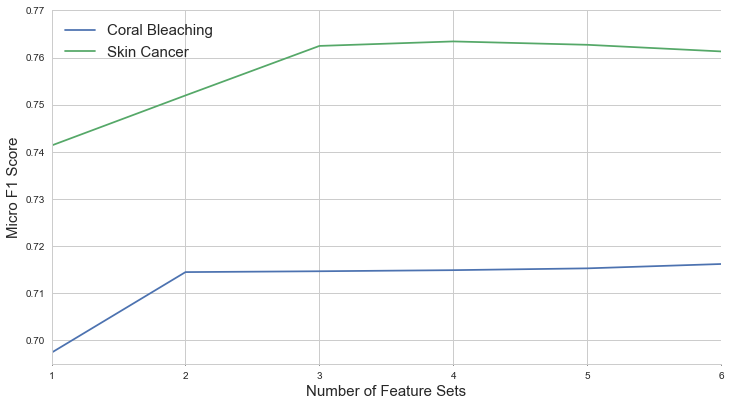

In [141]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

FONT_SIZE = 15

df = by_feat_size

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(12,6.5))

x = df["count"].values
y_cb = df["micro_f1_score_CB"].values
y_sc = df["micro_f1_score_SC"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_cb, label="Coral Bleaching")
ax1.plot(x,y_sc, label="Skin Cancer")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 6])
ax1.set_ylim([0.695, 0.77])
ax1.set_xlabel('Number of Feature Sets', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize=10)
sns.despine()

plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/sr_parser_f1_score_by_num_feats.png")
plt.show()

## Generate Rows for LaTex Table

### F1 Score As Individual Features are Added

In [142]:
for i, row in df_f1_score_by_feat_size.iterrows():
    #pprint(row)
    
    feats_CB = format_lbl(row["new_feat_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]
    
    feats_SC = format_lbl(str(row["new_feat_SC"]))
    if feats_SC == "nan":
        feats_SC = "-"
        
    micro_f1_score_SC = row["micro_f1_score_SC"]
    if str(micro_f1_score_SC) != "nan":
        micro_f1_score_SC = "{0:0.4f}".format(micro_f1_score_SC)
    else:
        micro_f1_score_SC = "-"
    count = row["count"]
    print("{count} & {feat_cb} & {cb_f1:0.4f} & & {feat_sc} & {sc_f1}\\\\"\
          .format(count=count,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))

1 & single words & 0.6974 & & three words & 0.7413\\
2 & between word features & 0.7145 & & between word features & 0.7520\\
3 & label set & 0.7146 & & size features & 0.7625\\
4 & three words & 0.7149 & & single words & 0.7634\\
5 & third order & 0.7153 & & third order & 0.7627\\
6 & unigrams & 0.7162 & & valency & 0.7613\\


## Sanity Check - Do Any Datasets have Duplicate Feature Sets with Different F1 Scores?

In [150]:
#SH: There were some issues with the CB_VD dataset initially for a couple of collections
for df in [cb_td_df, cb_vd_df, sc_td_df, sc_vd_df]:
    gb = group_by(df, bycols=["hs_feats","stemmed"], agg_map=[
        ("micro_f1_score", "count"),
        ("micro_f1_score", "min"),
        ("micro_f1_score", "max"),
    ])
    gb = gb[gb["count(micro_f1_score)"] > 1]
    miss_match = gb[gb["min(micro_f1_score)"] != gb["max(micro_f1_score)"]]
    
    assert len(miss_match) == 0, "Some errors occurred during data capture"

,count,feats,micro_f1_score,micro_precision,micro_recall
53,1,[single_words],0.697368,0.749045,0.652362
5,2,"[single_words, between_word_features]",0.714465,0.776866,0.661344
3,3,"[single_words, between_word_features, label_set]",0.714645,0.775916,0.662342
2,4,"[single_words, between_word_features, label_se...",0.714877,0.778300,0.661011
1,5,"[single_words, between_word_features, label_se...",0.715260,0.776911,0.662675
0,6,"[single_words, between_word_features, label_se...",0.716182,0.777259,0.664005


### Compute Reduction in Features

In [185]:
df = cb_vd_df
best_row = df.sort_values("micro_f1_score").tail(1)

max_feats = best_row["count"].values[0]

sub = df[df["count"] == max_feats-1].sort_values("micro_f1_score")
feats = sub.tail(1)["feats"].values[0]
num_feats = sub.tail(1)["num_feats"].values[0]

max_ft_df = (df[df["count"] == max_feats]).copy()
max_ft_df["diff"] = max_ft_df["num_feats"] - num_feats
diffs = max_ft_df["diff"].sum()
total_feats = diffs + num_feats
# diffs, total_feats
act_feats = best_row["num_feats"].values[0]
act_feats,total_feats, act_feats/total_feats

(33944.0, 123452.0, 0.2749570683342514)

In [188]:
df = sc_vd_df
best_row = df.sort_values("micro_f1_score").tail(1)

max_feats = df["count"].max()

sub = df[df["count"] == max_feats-1].sort_values("micro_f1_score")
#feats = sub.tail(1)["feats"].values[0]
num_feats = sub.tail(1)["num_feats"].values[0]

max_ft_df = (df[df["count"] == max_feats]).copy()
max_ft_df["diff"] = max_ft_df["num_feats"] - num_feats
diffs = max_ft_df["diff"].sum()
total_feats = diffs + num_feats
# diffs, total_feats
act_feats = best_row["num_feats"].values[0]
act_feats,total_feats,act_feats/total_feats

(25512.8, 123306.8, 0.20690505308709656)

In [193]:
cb_vd_df[cb_vd_df["stemmed"] == False].sort_values("micro_f1_score", ascending=False).head(1)\
[["count","feats","micro_f1_score","micro_precision","micro_recall"]]

,count,feats,micro_f1_score,micro_precision,micro_recall
7,3,"[single_words, between_word_features, label_set]",0.713952,0.775654,0.661344


In [205]:
cb_vd_df[(cb_vd_df["stemmed"] == True) & (cb_vd_df["count"] == 3)].sort_values("micro_f1_score", ascending=False).head(1)\
[["count","feats","micro_f1_score","micro_precision","micro_recall"]]

,count,feats,micro_f1_score,micro_precision,micro_recall
3,3,"[single_words, between_word_features, label_set]",0.714645,0.775916,0.662342


In [194]:
cb_vd_df[cb_vd_df["stemmed"] == True].sort_values("micro_f1_score", ascending=False).head(1)\
[["count","feats","micro_f1_score","micro_precision","micro_recall"]]

,count,feats,micro_f1_score,micro_precision,micro_recall
0,6,"[single_words, between_word_features, label_se...",0.716182,0.777259,0.664005


In [197]:
sc_vd_df[cb_vd_df["stemmed"] == False].sort_values("micro_f1_score", ascending=False).head(1)\
[["count","feats","micro_f1_score","micro_precision","micro_recall"]]

,count,feats,micro_f1_score,micro_precision,micro_recall
7,4,"[three_words, between_word_features, single_wo...",0.760841,0.825647,0.705468


In [198]:
sc_vd_df[cb_vd_df["stemmed"] == True].sort_values("micro_f1_score", ascending=False).head(1)\
[["count","feats","micro_f1_score","micro_precision","micro_recall"]]

,count,feats,micro_f1_score,micro_precision,micro_recall
0,4,"[three_words, between_word_features, size_feat...",0.763427,0.831203,0.705871
